# Quantum linear solver with LCU of Chebyshev polynomials

The code here can be integrated as part of a larger CFD solver, e.g., as in [qc-cfd repository](https://github.com/rolls-royce/qc-cfd/tree/main/1D-Nozzle).
In particular, instead of calling a classical solver, e.g., `x = sparse.linalg.spsolve(mat_raw_scr, b_raw)`, one can call the quantum solver `cheb_lcu_solver(mat_raw_scr, b_raw,...)`.

We implemented two versions for block-encoding, one based on Pauli decomposition of the matrix, and another one based on decomposing the matrix to a finite set of diagonals.

In [1]:
!pip install -qq "classiq[qsp]"
!pip install -qq "classiq[chemistry]"

In [2]:
import time

import matplotlib.pyplot as plt
import numpy as np
from cheb_utils import *
from classical_functions_be import *
from quantum_functions_be import *
from scipy import sparse

from classiq import *
from classiq.applications.chemistry.op_utils import qubit_op_to_pauli_terms

np.random.seed(53)

In [3]:
@qfunc
def my_reflect_about_zero(qba: QArray):
    reflect_about_zero(qba)
    RY(2 * np.pi, qba[0])


@qfunc
def walk_operator(
    block_enc: QCallable[QArray, QArray], block: QArray, data: QArray
) -> None:
    block_enc(block, data)
    my_reflect_about_zero(block)


@qfunc
def symmetrize_walk_operator(
    block_enc: QCallable[QNum, QArray], block: QNum, data: QArray
):
    my_reflect_about_zero(block)
    within_apply(
        lambda: walk_operator(block_enc, block, data),
        lambda: my_reflect_about_zero(block),
    )


@qfunc
def lcu_cheb(
    powers: CArray[CInt],
    inv_coeffs: CArray[CReal],
    block_enc: QCallable[QNum, QArray],
    mat_block: QNum,
    data: QArray,
    cheb_block: QArray,
) -> None:

    within_apply(
        lambda: inplace_prepare_state(inv_coeffs, 0.0, cheb_block),
        lambda: (
            Z(cheb_block[0]),
            repeat(
                powers.len,
                lambda i: control(
                    cheb_block[i],
                    lambda: power(
                        powers[i],
                        lambda: symmetrize_walk_operator(block_enc, mat_block, data),
                    ),
                ),
            ),
            my_reflect_about_zero(mat_block),
            walk_operator(block_enc, mat_block, data),
        ),
    )

Define functions to get properties of the block-encoding.

In [4]:
PAULI_TRIM_REL_TOL = 0.1


def get_pauli_sym_be(mat_raw_scr):
    """
    Get relevant block-encoding properties for `lcu_paulis_graycode` block encoding,
    with matrix symmetrization.

    Parameters
    ----------
    mat_raw_scr : scipy.sparse.spmatrix
        Square sparse matrix of shape (N, N), real or complex, to be block-encoded.

    Returns
    -------
    data_size : int
       Size of the data variable.
    block_size : int
        Size of the block variable.
    be_scaling_factor : float
        The scaling factor of the block-encoding unitary
    be_qfunc : qfunc
        Quantum function that implements the block encoding. Signature:
        be_qfunc(block: QNum, data: QNum) → None
    """

    rval = mat_raw_scr.data
    col = mat_raw_scr.indices
    rowstt = mat_raw_scr.indptr
    nr = mat_raw_scr.shape[0]
    data_size = int(np.log2(nr))

    # decompose to Paulis with symmetrizing
    paulis_list, transform_matrix = initialize_paulis_from_csr(
        rowstt, col, data_size, to_symmetrize=True
    )
    data_size += 1  # in the symmetric case the data size is increased by 1

    qubit_op = eval_pauli_op(paulis_list, transform_matrix, rval)
    qubit_op.compress(1e-12)
    hamiltonian = qubit_op_to_pauli_terms(qubit_op)
    hamiltonian_trimmed = trim_hamiltonian(
        hamiltonian, PAULI_TRIM_REL_TOL, jump_threshold=1.1
    )

    be_scaling_factor = sum(
        [np.abs(term.coefficient) for term in hamiltonian_trimmed.terms]
    )
    block_size = size = max(1, (len(hamiltonian_trimmed.terms) - 1).bit_length())

    hamiltonian_trimmed = hamiltonian_trimmed * (1 / be_scaling_factor)

    print(
        f"number of Paulis before/after trimming {len(hamiltonian.terms)}/{len(hamiltonian_trimmed.terms)}"
    )

    # Define block encoding function
    @qfunc
    def be_qfunc(block: QNum, data: QNum):
        lcu_paulis_graycode(hamiltonian_trimmed.terms, data, block)

    return data_size, block_size, be_scaling_factor, be_qfunc


def get_banded_diags_sym_be(mat_raw_scr):
    """
    Get relevant block-encoding properties for `block_encode_banded_sym` block encoding,

    Parameters
    ----------
    mat_raw_scr : scipy.sparse.spmatrix
        Square sparse matrix of shape (N, N), real or complex, to be block-encoded.

    Returns
    -------
    data_size : int
       Size of the data variable.
    block_size : int
        Size of the block variable.
    be_scaling_factor : float
        The scaling factor of the block-encoding unitary
    be_qfunc : qfunc
        Quantum function that implements the block encoding. Signature:
        be_qfunc(block: QNum, data: QNum) → None
    """
    offsets, diags, diags_maxima, prepare_norm = get_be_banded_data(mat_raw_scr)
    data_size = int(np.ceil(np.log2(len(diags[0])))) + 1

    # Calculate scaling factor and block size
    block_size = int(np.ceil(np.log2(len(offsets)))) + 3
    be_scaling_factor = 2 * prepare_norm

    # Define block encoding function
    @qfunc
    def be_qfunc(block: QNum, data: QNum):
        block_encode_banded_sym(
            offsets=offsets, diags=diags, prep_diag=diags_maxima, block=block, data=data
        )

    return data_size, block_size, be_scaling_factor, be_qfunc

The solvers were developed in the framework of exploring their performance in hybrid CFD schemes. For simplicity, it is assumed that all the properties of the matrices are known explicitly. In particular, we calculate its sigular values for identyfing the range in which we apply the inversion polnomial.

In [5]:
def get_eig_range(mat_raw_scr):
    mat_raw = mat_raw_scr.toarray()
    raw_size = mat_raw.shape[0]
    mat_sym = np.block(
        [
            [np.zeros([raw_size, raw_size]), np.transpose(mat_raw)],
            [mat_raw, np.zeros([raw_size, raw_size])],
        ]
    )
    w, v = np.linalg.eig(mat_sym)
    w_min = np.min(np.abs(w))
    w_max = np.max(np.abs(w))
    return w_min, w_max

In [6]:
def cheb_lcu_solver(
    mat_raw_scr,
    b_raw,
    log_poly_degree,
    be_method="banded",
    cheb_approx_type="numpy_interpolated",
    preferences=Preferences(),
    constraints=Constraints(),
    qmod_name=None,
):

    SCALE = 0.5
    b_norm = np.linalg.norm(b_raw)  # b normalization
    b_normalized = b_raw / b_norm
    data_size = max(1, (len(b_raw) - 1).bit_length()) + 1

    # Define block encoding
    if be_method == "pauli":
        data_size, block_size, be_scaling_factor, be_qfunc = get_pauli_sym_be(
            mat_raw_scr
        )
    if be_method == "banded":
        data_size, block_size, be_scaling_factor, be_qfunc = get_banded_diags_sym_be(
            mat_raw_scr
        )

    # Get eigenvalues range
    w_min, w_max = get_eig_range(mat_raw_scr / be_scaling_factor)

    # Calculate approximated Chebyshev polynomial
    poly_degree = 2 * 2**log_poly_degree
    pcoefs = get_cheb_coeff(
        w_min, poly_degree, w_max, scale=SCALE, method=cheb_approx_type, epsilon=0.01
    )
    odd_coef = pcoefs[1::2]

    # Calculate prep for Chebyshev LCU
    lcu_size_inv = len(odd_coef).bit_length() - 1
    print(f"Chebyshec LCU size: {lcu_size_inv} qubits.")
    normalization_inv = sum(np.abs(odd_coef))
    print(f"Normalization factor for inversion: {normalization_inv}")
    prepare_probs_inv = (np.abs(odd_coef) / normalization_inv).tolist()

    @qfunc
    def main(
        matrix_block: Output[QNum[block_size]],
        data: Output[QNum[data_size]],
        inv_block: Output[QNum[lcu_size_inv]],
    ):
        allocate(inv_block)
        allocate(matrix_block)
        allocate(data)

        data_array = QArray()
        within_apply(
            lambda: bind(data, data_array),
            lambda: (
                inplace_prepare_amplitudes(
                    b_normalized.tolist(), 0.0, data_array[0 : data_size - 1]
                ),
                X(data_array[data_size - 1]),
            ),
        )
        lcu_cheb(
            powers=[2**i for i in range(lcu_size_inv)],
            inv_coeffs=prepare_probs_inv,
            block_enc=be_qfunc,
            mat_block=matrix_block,
            data=data,
            cheb_block=inv_block,
        )

    if qmod_name is not None:
        write_qmod(main, qmod_name, symbolic_only=False)

    start_time_syn = time.time()
    qprog = synthesize(main, preferences=preferences, constraints=constraints)

    print("time to syn:", time.time() - start_time_syn)

    execution_preferences = ExecutionPreferences(
        num_shots=1,
        backend_preferences=ClassiqBackendPreferences(
            backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR
        ),
    )

    start_time_exe = time.time()
    with ExecutionSession(qprog, execution_preferences) as es:
        es.set_measured_state_filter("matrix_block", lambda state: state == 0.0)
        es.set_measured_state_filter("inv_block", lambda state: state == 0.0)
        results = es.sample()
    print("time to exe:", time.time() - start_time_exe)

    resulting_state = get_projected_state_vector(results, "data")

    normalization_factor = (
        (be_scaling_factor * SCALE * w_min) / b_norm / normalization_inv
    )

    return resulting_state / normalization_factor, qprog

In [7]:
import pathlib

path = (
    pathlib.Path(__file__).parent.resolve()
    if "__file__" in locals()
    else pathlib.Path(".")
)

In [8]:
mat_name = "nozzle_small_scr"
matfile = "matrices/" + mat_name + ".npz"
mat_raw_scr = sparse.load_npz(path / matfile)

b_raw = np.load(path / "matrices/b_nozzle_small.npy")
raw_mat_qubits = len(b_raw).bit_length() - 1  # matrix raw size

print(f"Raw matrix size: {raw_mat_qubits} qubits.")

Raw matrix size: 3 qubits.


In [9]:
# For faster results use the commented out preferences

prefs = Preferences()

# prefs = Preferences(
#     transpilation_option="none", optimization_level=0, debug_mode=False, qasm3=True
# )

log_poly_degree = 4

In [10]:
qsol_banded, qprog_cheb_lcu_banded = cheb_lcu_solver(
    mat_raw_scr,
    b_raw,
    log_poly_degree,
    be_method="banded",
    preferences=prefs,
    constraints=Constraints(optimization_parameter="width"),
    qmod_name="cheb_lcu_solver_banded_be",
)
show(qprog_cheb_lcu_banded)

For error 0.01, and given kappa, the needed polynomial degree is: 1293
Performing numpy Chebyshev interpolation, with degree 32
Chebyshec LCU size: 4 qubits.
Normalization factor for inversion: 0.15033564980341882
time to syn: 144.29120779037476
time to exe: 46.127877950668335
Quantum program link: https://platform.classiq.io/circuit/34wLR6QlTKZi3elCLfGNeQhgR6p


In [11]:
qsol_pauli, qprog_cheb_lcu_pauli = cheb_lcu_solver(
    mat_raw_scr,
    b_raw,
    log_poly_degree,
    be_method="pauli",
    preferences=prefs,
    constraints=Constraints(optimization_parameter="width"),
    qmod_name="cheb_lcu_solver_pauli_be",
)
show(qprog_cheb_lcu_pauli)

number of Paulis before/after trimming 24/20
For error 0.01, and given kappa, the needed polynomial degree is: 885
Performing numpy Chebyshev interpolation, with degree 32
Chebyshec LCU size: 4 qubits.
Normalization factor for inversion: 0.21061716904989833
time to syn: 93.29885578155518
time to exe: 13.074339151382446
Quantum program link: https://platform.classiq.io/circuit/34wLetuvacK2iDnxheo0G1lCAtg


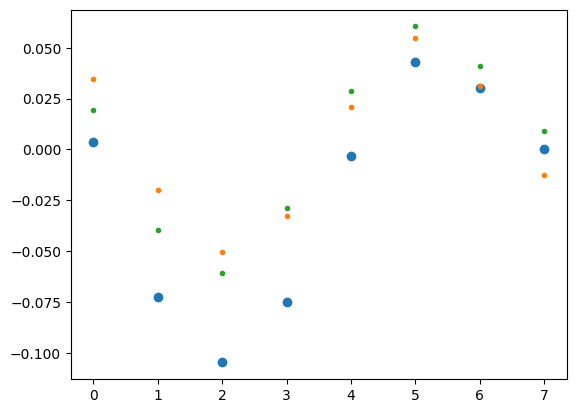

In [12]:
mat_raw = mat_raw_scr.toarray()
expected_sol = np.linalg.solve(mat_raw, b_raw)
plt.plot(expected_sol, "o", label="classical")
ext_idx = np.argmax(np.abs(expected_sol))
correct_sign = np.sign(expected_sol[ext_idx]) / np.sign(qsol_banded[ext_idx])
qsol_banded *= correct_sign
plt.plot(
    qsol_banded[0 : len(b_raw)],
    ".",
    label=f"Cheb-LCU-inv; Banded BE; degree {2*2**log_poly_degree+1}",
)
correct_sign = np.sign(expected_sol[ext_idx]) / np.sign(qsol_pauli[ext_idx])
qsol_pauli *= correct_sign
plt.plot(
    qsol_pauli[0 : len(b_raw)],
    ".",
    label=f"Cheb-LCU-inv; Pauli BE; degree {2*2**log_poly_degree+1}",
)

In [13]:
assert np.linalg.norm(qsol_banded[0 : len(b_raw)] - expected_sol) < 0.25
assert np.linalg.norm(qsol_pauli[0 : len(b_raw)] - expected_sol) < 0.2